# NYC Taxi Fare Prediction

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgbm
import xgboost as xgb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/8. Summer 2022/CSE438/Project/dfy_2204_final.csv', nrows = 1500000)
test_df = pd.read_csv('/content/drive/MyDrive/8. Summer 2022/CSE438/Project/dfy_2203_test_dataset.csv')
df.shape, test_df.shape

((1500000, 7), (50, 6))

In [4]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount
0,2022-04-01 00:21:13,2022-04-01 00:58:33,163,62,10.30,1.0,33.5
1,2022-04-01 00:07:47,2022-04-01 00:19:12,142,141,2.00,0.0,10.0
2,2022-04-01 00:14:52,2022-04-01 00:23:43,79,148,1.00,1.0,7.0
3,2022-04-01 00:30:02,2022-04-01 00:45:06,79,13,2.60,1.0,12.0
4,2022-04-01 00:48:40,2022-04-01 01:03:34,238,116,2.79,1.0,-12.5


In [5]:
df.isnull().sum().sort_index()/len(df)

DOLocationID             0.0
PULocationID             0.0
fare_amount              0.0
passenger_count          0.0
tpep_dropoff_datetime    0.0
tpep_pickup_datetime     0.0
trip_distance            0.0
dtype: float64

In [6]:
df.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,1.650513e+02,1.633519e+02,3.411977e+00,1.405917e+00,1.423192e+01
std,6.531801e+01,7.015304e+01,4.437362e+00,9.781580e-01,1.354642e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-6.050000e+02
25%,1.320000e+02,1.130000e+02,1.100000e+00,1.000000e+00,7.000000e+00
50%,1.620000e+02,1.620000e+02,1.860000e+00,1.000000e+00,1.000000e+01
75%,2.340000e+02,2.340000e+02,3.410000e+00,1.000000e+00,1.550000e+01
max,2.650000e+02,2.650000e+02,7.494900e+02,9.000000e+00,1.256500e+03


In [7]:
df.drop(df[df['fare_amount'] < 2.5].index, axis=0, inplace = True)
df.drop(df[df['fare_amount'] > 500].index, axis=0, inplace = True)

In [8]:
test_df.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count
count,50.000000,50.000000,50.000000,50.000000
mean,147.700000,160.460000,5.865600,1.320000
std,48.120279,74.253622,5.770324,0.843704
min,25.000000,17.000000,0.100000,0.000000
25%,132.000000,112.500000,1.962500,1.000000
50%,138.000000,156.500000,3.235000,1.000000
75%,165.500000,229.750000,8.220000,1.000000
max,239.000000,262.000000,20.760000,5.000000


In [9]:
df[df['passenger_count'] > 5].sort_values('passenger_count')

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount
473,2022-04-01 00:02:44,2022-04-01 00:23:34,249,255,4.20,6.0,16.5
994011,2022-04-09 13:24:58,2022-04-09 13:34:41,114,79,0.87,6.0,7.5
994010,2022-04-09 13:07:05,2022-04-09 13:19:25,158,231,1.65,6.0,9.5
993730,2022-04-09 13:47:53,2022-04-09 14:05:34,158,164,1.97,6.0,12.0
993317,2022-04-09 13:18:34,2022-04-09 13:37:05,68,239,3.63,6.0,16.0
...,...,...,...,...,...,...,...
333656,2022-04-03 18:41:18,2022-04-03 18:41:21,138,264,0.00,8.0,55.0
1248504,2022-04-11 17:46:24,2022-04-11 17:46:27,132,132,0.00,8.0,75.0
64937,2022-04-01 15:08:38,2022-04-01 15:08:47,132,132,0.00,9.0,75.0
144466,2022-04-02 03:20:56,2022-04-02 03:21:00,265,265,0.00,9.0,300.0


In [10]:
df.drop(df[df['passenger_count'] > 5].index, axis=0, inplace = True)
df.drop(df[df['passenger_count'] == 0].index, axis=0, inplace = True)

In [11]:
df['tpep_pickup_datetime']  = pd.to_datetime(df['tpep_pickup_datetime'])
test_df['tpep_pickup_datetime']  = pd.to_datetime(test_df['tpep_pickup_datetime'])

In [12]:
df['Year'] = df['tpep_pickup_datetime'].dt.year
df['Month'] = df['tpep_pickup_datetime'].dt.month
df['Date'] = df['tpep_pickup_datetime'].dt.day
df['Day of Week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['Hour'] = df['tpep_pickup_datetime'].dt.hour
df.drop('tpep_pickup_datetime', axis = 1, inplace = True)

test_df['Year'] = test_df['tpep_pickup_datetime'].dt.year
test_df['Month'] = test_df['tpep_pickup_datetime'].dt.month
test_df['Date'] = test_df['tpep_pickup_datetime'].dt.day
test_df['Day of Week'] = test_df['tpep_pickup_datetime'].dt.dayofweek
test_df['Hour'] = test_df['tpep_pickup_datetime'].dt.hour
test_df.drop('tpep_pickup_datetime', axis = 1, inplace = True)

In [13]:
df.dropna(inplace=True)

In [14]:
df.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,Year,Month,Date,Day of Week,Hour
count,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06
mean,1.650695e+02,1.633562e+02,3.424334e+00,1.377157e+00,1.440917e+01,2.022000e+03,3.999946e+00,6.889070e+00,3.029972e+00,1.410366e+01
std,6.531543e+01,7.015454e+01,4.438322e+00,8.215960e-01,1.329434e+01,1.531318e-02,7.901660e-03,3.722735e+00,2.024563e+00,5.657182e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.320000e+02,1.130000e+02,1.100000e+00,1.000000e+00,7.000000e+00,2.022000e+03,4.000000e+00,4.000000e+00,1.000000e+00,1.100000e+01
50%,1.620000e+02,1.620000e+02,1.870000e+00,1.000000e+00,1.000000e+01,2.022000e+03,4.000000e+00,7.000000e+00,3.000000e+00,1.500000e+01
75%,2.340000e+02,2.340000e+02,3.420000e+00,1.000000e+00,1.550000e+01,2.022000e+03,4.000000e+00,1.000000e+01,5.000000e+00,1.800000e+01
max,2.650000e+02,2.650000e+02,7.494900e+02,5.000000e+00,5.000000e+02,2.022000e+03,4.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01


In [15]:
def optimize_floats(df):
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df):
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize(df):
    return optimize_floats(optimize_ints(df))

In [16]:
df = optimize(df)
test_df = optimize(test_df)

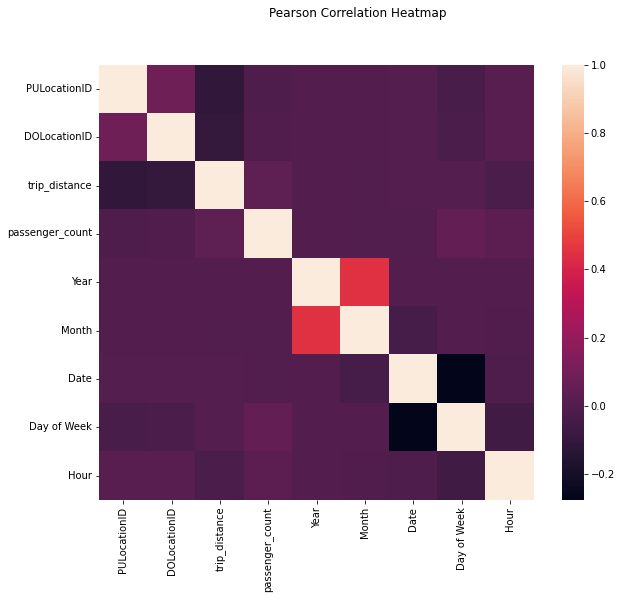

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('fare_amount', axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


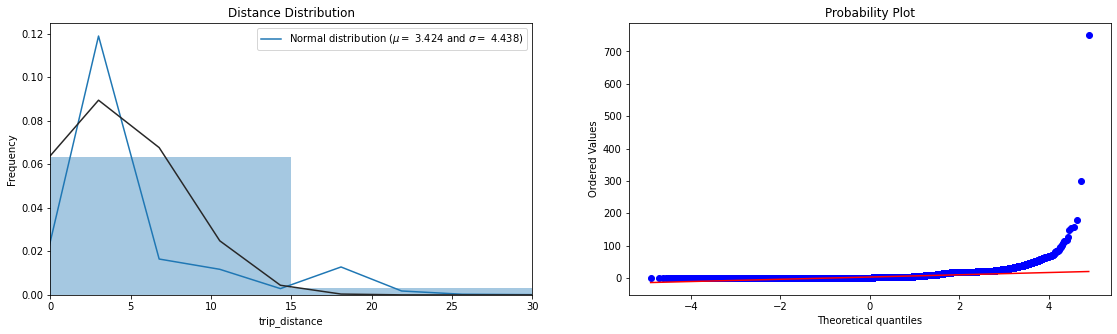

In [18]:
(mu, sigma) = norm.fit(df['trip_distance'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['trip_distance'] , fit=norm, ax=ax1)
ax1.set_xlim(0, 30)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Distance Distribution')
ax2 = stats.probplot(df['trip_distance'], plot=plt)
f.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


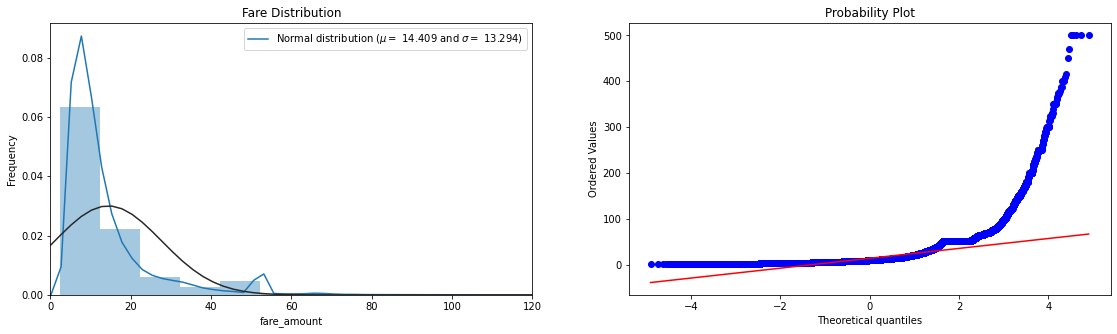

In [19]:
(mu, sigma) = norm.fit(df['fare_amount'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['fare_amount'] , fit=norm, ax=ax1)
ax1.set_xlim(0, 120)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Fare Distribution')
ax2 = stats.probplot(df['fare_amount'], plot=plt)
f.show();

In [20]:
df.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,Year,Month,Date,Day of Week,Hour
count,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06,1.441404e+06
mean,1.650695e+02,1.633562e+02,3.424333e+00,1.377157e+00,1.440917e+01,2.022000e+03,3.999946e+00,6.889070e+00,3.029972e+00,1.410366e+01
std,6.531543e+01,7.015454e+01,4.438322e+00,8.215960e-01,1.329434e+01,1.531318e-02,7.901660e-03,3.722735e+00,2.024563e+00,5.657182e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.320000e+02,1.130000e+02,1.100000e+00,1.000000e+00,7.000000e+00,2.022000e+03,4.000000e+00,4.000000e+00,1.000000e+00,1.100000e+01
50%,1.620000e+02,1.620000e+02,1.870000e+00,1.000000e+00,1.000000e+01,2.022000e+03,4.000000e+00,7.000000e+00,3.000000e+00,1.500000e+01
75%,2.340000e+02,2.340000e+02,3.420000e+00,1.000000e+00,1.550000e+01,2.022000e+03,4.000000e+00,1.000000e+01,5.000000e+00,1.800000e+01
max,2.650000e+02,2.650000e+02,7.494900e+02,5.000000e+00,5.000000e+02,2.022000e+03,4.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01


In [21]:
df = optimize(df)
test_df = optimize(test_df)

In [22]:
df.dtypes

tpep_dropoff_datetime     object
PULocationID               int16
DOLocationID               int16
trip_distance            float32
passenger_count          float32
fare_amount              float32
Year                       int16
Month                       int8
Date                        int8
Day of Week                 int8
Hour                        int8
dtype: object

In [23]:
df.drop('tpep_dropoff_datetime', axis = 1, inplace = True)
test_df.drop('tpep_dropoff_datetime', axis = 1, inplace = True)

In [24]:
X, y = df.drop('fare_amount', axis = 1), df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [25]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_df)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 700, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[0]	train-rmse:18.4614	valid-rmse:18.3577
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:4.6841	valid-rmse:4.99017
[100]	train-rmse:4.04958	valid-rmse:4.59385
[150]	train-rmse:3.86373	valid-rmse:4.55791
[200]	train-rmse:3.77387	valid-rmse:4.55814
[250]	train-rmse:3.68824	valid-rmse:4.56512
Stopping. Best iteration:
[159]	train-rmse:3.84106	valid-rmse:4.55534



In [26]:
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dvalid)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.9154349784004538
Test r2 score:  0.8804283471530652
Train RMSE: 3.6714
Test RMSE: 4.5674


In [28]:
test_preds = model.predict(dtest)

submission = pd.DataFrame(
    {'fare_amount': test_preds},
    columns = ['fare_amount'])
submission.to_csv('submission1.csv', index = False)